### Finetune GPT-4o Vision

**Steps:**
1. Use the pre-trained model
2. Prepare training data
3. Finetune the pre-trained model
4. Use the fine-tuned model

### 1. Use the pre-trained model

In [1]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from a .env file if present
client = OpenAI()

In [78]:
# Sample format

{
  "messages": [
    { "role": "system", 
     "content": "You are an assistant that identifies which part of the car is damaged and the severity level of the damage" },
    { "role": "user", 
     "content": "Identify which part of the car is damaged and the severity level of the damage."},
    { "role": "user", 
     "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": image_url
          }
        }
      ] 
    },
    { "role": "assistant", "content": "doors" }
  ]
}


NameError: name 'image_url' is not defined

In [ ]:
#Upload parts of data

In [186]:
# import os
# import requests

# API_KEY = os.environ["OPENAI_API_KEY"]
# filename = "/store/rsiva/code/navid_ws/NaVid-VLN-CE/tmp/gpt-dataset/new_small.jsonl"

# #filename = "/store/rsiva/code/navid_ws/NaVid-VLN-CE/tmp/gpt-dataset/navigation_training_data.jsonl"
# file_size = os.path.getsize(filename)

# create_url = "https://api.openai.com/v1/uploads"

# headers = {
#     "Authorization": f"Bearer {API_KEY}",
#     "Content-Type": "application/json",
# }

# data = {
#     "purpose": "fine-tune",
#     "filename": "navigation_training_data.jsonl",
#     "bytes": file_size,
#     "mime_type": "text/jsonl",
# }

# resp = requests.post(create_url, headers=headers, json=data)
# upload = resp.json()
# print(upload)
# upload_id = upload["id"]


{'id': 'upload_68bdf6d4acb08191a5ae37e3809e80fa', 'object': 'upload', 'bytes': 1123324560, 'created_at': 1757279956, 'filename': 'navigation_training_data.jsonl', 'purpose': 'fine-tune', 'status': 'pending', 'expires_at': 1757283556}


In [187]:
# PART_SIZE = 64 * 1024 * 1024  # 64 MB
# part_ids = []

# with open(filename, "rb") as f:
#     idx = 0
#     while True:
#         chunk = f.read(PART_SIZE)
#         if not chunk:
#             break

#         part_url = f"https://api.openai.com/v1/uploads/{upload_id}/parts"
#         resp = requests.post(
#             part_url,
#             headers={"Authorization": f"Bearer {API_KEY}"},
#             files={"data": chunk},
#         )
#         if resp.headers.get("content-type") == "application/json":
#             part = resp.json()
#         else:
#             print(f"Unexpected response (status {resp.status_code}): {resp.text}")
#             break

#         print(f"Uploaded part {idx}: {part}")
#         part_ids.append(part["id"])
#         idx += 1


Uploaded part 0: {'id': 'part_68bdf6e1421481918c5b63700ac272fe', 'object': 'upload.part', 'created_at': 1757279969, 'upload_id': 'upload_68bdf6d4acb08191a5ae37e3809e80fa'}
Uploaded part 1: {'id': 'part_68bdf6eaadf88191a5e1a43aad63aee4', 'object': 'upload.part', 'created_at': 1757279978, 'upload_id': 'upload_68bdf6d4acb08191a5ae37e3809e80fa'}
Uploaded part 2: {'id': 'part_68bdf6f318e48191b13a8674453c1f2e', 'object': 'upload.part', 'created_at': 1757279987, 'upload_id': 'upload_68bdf6d4acb08191a5ae37e3809e80fa'}
Uploaded part 3: {'id': 'part_68bdf7082aac819184985d82714870b6', 'object': 'upload.part', 'created_at': 1757280008, 'upload_id': 'upload_68bdf6d4acb08191a5ae37e3809e80fa'}
Uploaded part 4: {'id': 'part_68bdf7104c8c819198721bb0faf5ad5d', 'object': 'upload.part', 'created_at': 1757280016, 'upload_id': 'upload_68bdf6d4acb08191a5ae37e3809e80fa'}
Uploaded part 5: {'id': 'part_68bdf71361508191adf34328f429aa55', 'object': 'upload.part', 'created_at': 1757280019, 'upload_id': 'upload_68b

In [32]:
import os
import requests

API_KEY = os.environ["OPENAI_API_KEY"]
#filename = "/store/rsiva/code/navid_ws/NaVid-VLN-CE/tmp/gpt-dataset/navigation_training_data.jsonl"
filename =  "/store/rsiva/code/navid_ws/NaVid-VLN-CE/tmp/gpt-dataset/300step_merged_training.jsonl"
file_size = os.path.getsize(filename)

# Step 1: Create the upload
create_url = "https://api.openai.com/v1/uploads"
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json",
}

data = {
    "purpose": "fine-tune",
    "filename": os.path.basename(filename),
    "bytes": file_size,
    "mime_type": "text/jsonl",
}

resp = requests.post(create_url, headers=headers, json=data)
upload = resp.json()
print("Upload created:", upload)
upload_id = upload["id"]

Upload created: {'id': 'upload_68c26131eec48191a87a6dda35df467c', 'object': 'upload', 'bytes': 593673078, 'created_at': 1757569329, 'filename': '300step_merged_training.jsonl', 'purpose': 'fine-tune', 'status': 'pending', 'expires_at': 1757572929}


In [33]:
PART_SIZE = 64 * 1024 * 1024  # 64 MB
part_ids = []
uploaded_bytes = 0
idx = 0

with open(filename, "rb") as f:
    while uploaded_bytes < file_size:
        # Read only the remaining bytes for the last chunk
        remaining = file_size - uploaded_bytes
        chunk_size = min(PART_SIZE, remaining)
        chunk = f.read(chunk_size)

        part_url = f"https://api.openai.com/v1/uploads/{upload_id}/parts"
        resp = requests.post(
            part_url,
            headers={"Authorization": f"Bearer {API_KEY}"},
            files={"data": chunk},
        )

        # Check if response is JSON
        if resp.headers.get("content-type") == "application/json":
            part = resp.json()
            part_ids.append(part["id"])
            print(f"Uploaded part {idx}: {part}")
        else:
            print(f"Unexpected response (status {resp.status_code}): {resp.text}")
            break

        uploaded_bytes += len(chunk)
        idx += 1

print("All parts uploaded successfully!")
print("Part IDs:", part_ids)

Uploaded part 0: {'id': 'part_68c26145380481918eacbc541296103c', 'object': 'upload.part', 'created_at': 1757569349, 'upload_id': 'upload_68c26131eec48191a87a6dda35df467c'}
Uploaded part 1: {'id': 'part_68c2615581608191b9733b1790175715', 'object': 'upload.part', 'created_at': 1757569365, 'upload_id': 'upload_68c26131eec48191a87a6dda35df467c'}
Uploaded part 2: {'id': 'part_68c2615c10f0819188f8372611dcd3ba', 'object': 'upload.part', 'created_at': 1757569372, 'upload_id': 'upload_68c26131eec48191a87a6dda35df467c'}
Uploaded part 3: {'id': 'part_68c2616470b48191b50905d3e93e2277', 'object': 'upload.part', 'created_at': 1757569380, 'upload_id': 'upload_68c26131eec48191a87a6dda35df467c'}
Uploaded part 4: {'id': 'part_68c2616e0ddc8191a107c52f42369414', 'object': 'upload.part', 'created_at': 1757569390, 'upload_id': 'upload_68c26131eec48191a87a6dda35df467c'}
Uploaded part 5: {'id': 'part_68c261762e6c8191a85327562af8f0c1', 'object': 'upload.part', 'created_at': 1757569398, 'upload_id': 'upload_68c

In [34]:
complete_url = f"https://api.openai.com/v1/uploads/{upload_id}/complete"
resp = requests.post(
    complete_url,
    headers=headers,
    json={"part_ids": part_ids},
)
completed = resp.json()
print(completed)

file_id = completed["file"]["id"]
print("Final File ID:", file_id)


{'id': 'upload_68c26131eec48191a87a6dda35df467c', 'object': 'upload', 'bytes': 593673078, 'created_at': 1757569329, 'filename': '300step_merged_training.jsonl', 'purpose': 'fine-tune', 'status': 'completed', 'expires_at': 1757572929, 'file': {'object': 'file', 'id': 'file-EnYDWZnRX7dDReVttBCSTm', 'purpose': 'fine-tune', 'filename': '300step_merged_training.jsonl', 'bytes': 593673078, 'created_at': 1757569329, 'expires_at': None, 'status': 'processed', 'status_details': None}}
Final File ID: file-EnYDWZnRX7dDReVttBCSTm


### 2. Finetune model


In [179]:
#response = client.files.delete("file-Gc8NTB9rmpDyACWvjhhi9d")
#response
file_id = "file-D1mG9sRtpPGUijtu6PjqL2"

In [35]:
response = client.fine_tuning.jobs.create(
    training_file=file_id,
    model="gpt-4.1-2025-04-14", # Replace with our finetuned model to use it as a checkpoint
    hyperparameters={"n_epochs": 1}
    #validation_file
)

print("Fine-tune job is started")
print(response)
ft_job_id = response.id


Fine-tune job is started
FineTuningJob(id='ftjob-2oZwtCXK54sM9m7gkBGyiKJa', created_at=1757569489, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4.1-2025-04-14', object='fine_tuning.job', organization_id='org-6S5CZI9GpGCluYXm8Sl8zN8n', result_files=[], seed=1026214971, status='validating_files', trained_tokens=None, training_file='file-EnYDWZnRX7dDReVttBCSTm', validation_file=None, estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None)


In [2]:
# Your fine-tuning job IDs
jobs = {
    "Method 1": "ftjob-anqUnWooZZYMKmX9MtFsTePD",
    "Method 2": "ftjob-Mvw5QnUQRkHbmxQetSc6tUl0",
    "Method 3": "ftjob-2oZwtCXK54sM9m7gkBGyiKJa"
}

for label, job_id in jobs.items():
    try:
        job = client.fine_tuning.jobs.retrieve(job_id)
        print(f"=== {label} ===")
        print(f"ID: {job.id}")
        print(f"Status: {job.status}")
        print(f"Model: {job.fine_tuned_model}")
        print(f"Created: {job.created_at}")
        print(f"Trained tokens: {job.trained_tokens}")
        print()
    except Exception as e:
        print(f"Error retrieving {label} ({job_id}): {e}")

=== Method 1 ===
ID: ftjob-anqUnWooZZYMKmX9MtFsTePD
Status: succeeded
Model: ft:gpt-4.1-2025-04-14:ut-autonomous::CEURhSrA
Created: 1757567704
Trained tokens: 1550187

=== Method 2 ===
ID: ftjob-Mvw5QnUQRkHbmxQetSc6tUl0
Status: succeeded
Model: ft:gpt-4.1-2025-04-14:ut-autonomous::CEVk7wfn
Created: 1757569145
Trained tokens: 1725043

=== Method 3 ===
ID: ftjob-2oZwtCXK54sM9m7gkBGyiKJa
Status: succeeded
Model: ft:gpt-4.1-2025-04-14:ut-autonomous::CEV9xiq1
Created: 1757569489
Trained tokens: 1569047



In [25]:

jobs = client.fine_tuning.jobs.list()

matching = [job for job in jobs.data if job.training_file == "file-5jvUziEV9ohWG5vgG8CCM8"] # this is our 1500 samples off base



if matching:
    for job in matching:
        print(f"Job ID: {job.id}")
        print(f"  Status: {job.status}")
        print(f"  Model: {job.model}")
        print(f"  Created at: {job.created_at}")
        print(f"  Training file: {job.training_file}")
        if job.fine_tuned_model:
            print(f"  Fine-tuned Model: {job.fine_tuned_model}")
        print("-" * 40)
else:
    print("No jobs found using that training file.")

Job ID: ftjob-anqUnWooZZYMKmX9MtFsTePD
  Status: running
  Model: gpt-4.1-2025-04-14
  Created at: 1757567704
  Training file: file-5jvUziEV9ohWG5vgG8CCM8
----------------------------------------


In [234]:
from openai import OpenAI
import os

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

job_id = "ftjob-onhyVbCJtoCA5WYtOZWEVHfo"  # this is our 1500 samples off our already finetuned model


job = client.fine_tuning.jobs.retrieve(job_id)

print(f"Job ID: {job.id}")
print(f"Status: {job.status}")
if hasattr(job, "error") and job.error:
    print("Error details:")
    print(job.error)


Job ID: ftjob-onhyVbCJtoCA5WYtOZWEVHfo
Status: running
Error details:
Error(code=None, message=None, param=None)


In [43]:
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=ft_job_id, limit=10)
response

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-WKT7NTdpC8S9KTvqDfmCWgNU', created_at=1757271622, level='info', message='Fine-tuning job started', object='fine_tuning.job.event', data=None, type='message'), FineTuningJobEvent(id='ftevent-DB5uv05dTFAkCm8C0us1t1F6', created_at=1757271618, level='info', message='Files validated, moving job to queued state', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-IoAB1ontNd9nJ9fMZuTVLxhe', created_at=1757271535, level='info', message='Scanning images in file file-3oneKDh6WBMJSSTsWiYKbA. This may take some time.', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-wENbfwT4xkokBhZ4Zddtmkhw', created_at=1757271531, level='info', message='Validating training file: file-3oneKDh6WBMJSSTsWiYKbA', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-zQ2pdievI4T0qfoVgACYdcUF', created_at=1757271531, level='info', messag

In [18]:
job_id = "ftjob-OjReCFNkmcnVxuOpl62Gu3AB"


response = client.fine_tuning.jobs.cancel(fine_tuning_job_id=job_id)
print(f"Fine-tuning job {job_id} successfully cancelled.")
print(response)


Fine-tuning job ftjob-OjReCFNkmcnVxuOpl62Gu3AB successfully cancelled.
FineTuningJob(id='ftjob-OjReCFNkmcnVxuOpl62Gu3AB', created_at=1757566954, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=1), model='gpt-4.1-2025-04-14', object='fine_tuning.job', organization_id='org-6S5CZI9GpGCluYXm8Sl8zN8n', result_files=[], seed=733931990, status='cancelled', trained_tokens=None, training_file='file-DRyitwMCDZtgPpLhDd1kXG', validation_file=None, estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=1))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None)


First line raw:
{"messages": [{"role": "system", "content": "You are an AI navigation agent inside a simulated environment. Your job is to move from your START location to a GOAL location using your top-down map and camera view.\n\n=== MAP LEGEND ===\n- BLUE SQUARE: Your starting position.\n- BLUE ARROW: Your current position & facing direction.\n- BLUE LINE: Your path so far.\n- RED SQUARE: The goal location you must reach.\n- GRAY AREAS: Navigable floor where you can walk.\n- WHITE AREAS: Obstacles or walls you cannot walk through.\n\n=== NAVIGATION PRINCIPLES ===\n1. Always identify the RED SQUARE (goal) on the map.\n2. Compare your CURRENT CARDINAL DIRECTION (N, NE, E, SE, S, SW, W, NW) with the DIRECTION from your location to the goal.\n3. If not facing toward the goal, turn left (2) or right (3) to align your heading.\n4. Move forward (1) only when facing an open navigable path toward the goal using the FRONT VIEW CAMERA.\n5. Avoid white (non-navigable) areas \u2014 if blocked, r
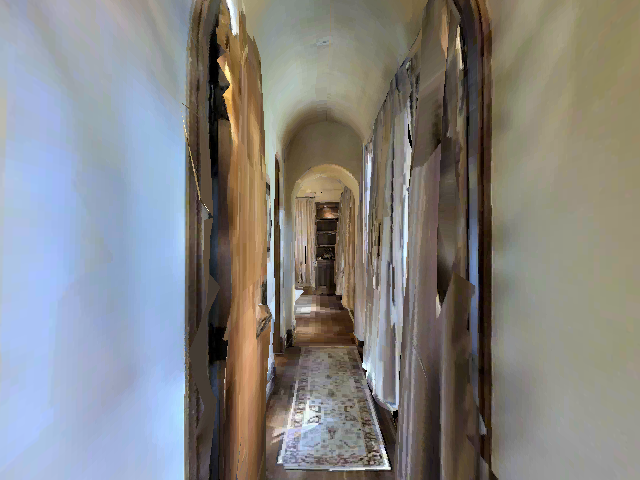
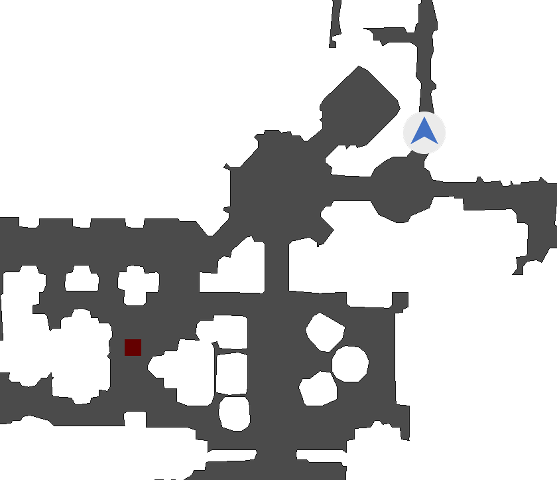
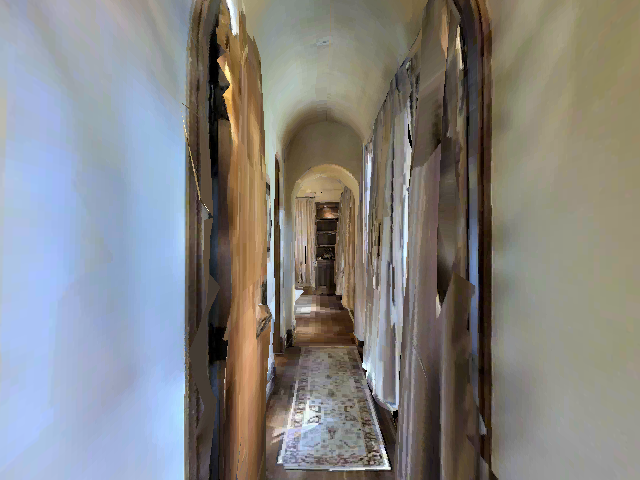
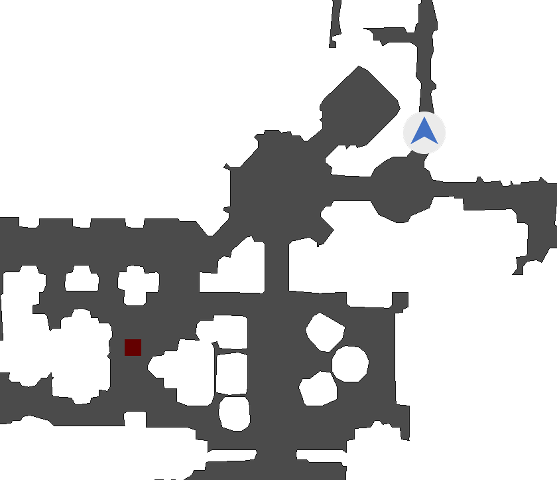

In [31]:
import json

file_path = "/store/rsiva/code/navid_ws/NaVid-VLN-CE/tmp/gpt-dataset/navigation_training_data.jsonl"

with open(file_path, "r") as f:
    first_line = f.readline().strip()

print("First line raw:")
print(first_line)

try:
    sample = json.loads(first_line)
    print("\n✅ Valid JSON object:")
    print(json.dumps(sample, indent=2))
except json.JSONDecodeError as e:
    print("\n❌ Invalid JSON:", e)


In [98]:
ft_job_id = "ftjob-RDxNBpSIN818ep2v8T6bA4bf"
response = client.fine_tuning.jobs.retrieve(ft_job_id)
print(response)

FineTuningJob(id='ftjob-cf9NYJg7ITmCAmVSHAbpyZer', created_at=1757271531, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4.1-2025-04-14:ut-autonomous::CDF2lYZQ', finished_at=1757272126, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=1), model='gpt-4.1-2025-04-14', object='fine_tuning.job', organization_id='org-6S5CZI9GpGCluYXm8Sl8zN8n', result_files=['file-XTAjTpFroeSfJWe4iWMFhU'], seed=380361608, status='succeeded', trained_tokens=32911, training_file='file-3oneKDh6WBMJSSTsWiYKbA', validation_file=None, estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=1))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None)


In [99]:
result_files = response.result_files
result_files

['file-XTAjTpFroeSfJWe4iWMFhU']

### 3. Use the finetuned model

In [100]:
fine_tuned_model = response.fine_tuned_model
fine_tuned_model

'ft:gpt-4.1-2025-04-14:ut-autonomous::CDF2lYZQ'

In [102]:
from openai import OpenAI
from io import BytesIO
from PIL import Image
import base64

client = OpenAI()

# Function to encode image to base64
def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        image = Image.open(image_file)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode("utf-8")

# Paths to your images
rgb_path = "/store/rsiva/code/navid_ws/NaVid-VLN-CE/tmp/gpt-dataset/rgb/rgb_94_00024.png"
map_path = "/store/rsiva/code/navid_ws/NaVid-VLN-CE/tmp/gpt-dataset/map/map_94_00024.png"

rgb_b64 = encode_image_to_base64(rgb_path)
map_b64 = encode_image_to_base64(map_path)

# Example parameters for creating user prompt
current_direction = "E"
current_yaw = 90.0
distance_to_goal = 10
history_text = "Previous steps: Move forward, Turn left"
def create_system_prompt() -> str:
    """Create the system prompt from the provided code"""
    return (
        "You are an AI navigation agent inside a simulated environment. "
        "Your job is to move from your START location to a GOAL location using your top-down map and camera view.\n\n"
        "=== MAP LEGEND ===\n"
        "- BLUE SQUARE: Your starting position.\n"
        "- BLUE ARROW: Your current position & facing direction.\n"
        "- BLUE LINE: Your path so far.\n"
        "- RED SQUARE: The goal location you must reach.\n"
        "- GRAY AREAS: Navigable floor where you can walk.\n"
        "- WHITE AREAS: Obstacles or walls you cannot walk through.\n\n"
        "=== NAVIGATION PRINCIPLES ===\n"
        "1. Always identify the RED SQUARE (goal) on the map.\n"
        "2. Compare your CURRENT CARDINAL DIRECTION (N, NE, E, SE, S, SW, W, NW) with the DIRECTION from your location to the goal.\n"
        "3. If not facing toward the goal, turn left (2) or right (3) to align your heading.\n"
        "4. Move forward (1) only when facing an open navigable path toward the goal using the FRONT VIEW CAMERA.\n"
        "5. Avoid white (non-navigable) areas — if blocked, reorient using the map.\n"
        "6. Stop (0) when you reach the goal on the top-down map (ONLY when blue arrow is touching or on top of red square).\n\n"
        "7. Use distance-to-goal as feedback: if it's close to zero, you are near the goal, and you should Stop(0).\n"
        "If it increases or stays constant for several steps, adjust strategy.\n\n"
        "=== DECISION RULES ===\n"
        "- Use top-down map to determine direction to move in.\n"
        "- Every step, make a micro-plan: identify goal direction, check navigability, choose turn/move.\n"
        "- If goal is to your left/right on the map, rotate toward it before moving.\n"
        "- Use global cardinal directions for reasoning, NOT relative left/right from the camera.\n\n"
        "=== HISTORY INTERPRETATION RULES ===\n"
        "- If Collision=True, treat it as a collision (forward failed) → reroute using a different action.\n"
        "- If the last few actions are all turns (2 or 3) and orientation is nearly unchanged, you are looping → choose a different strategy (try forward or opposite turn).\n"
        "- Use history and past path to avoid repeating the same failed action sequence.\n"
        "=== OUTPUT FORMAT ===\n"
        "Action: [0-3]\n"
    )
# Create user text using your function
def create_user_text(current_direction, current_yaw, distance_to_goal, history_text):
    user_text = (
        f"Navigate to approach the red square on the top down map using the top-down map and camera view.\n\n"
        f"TASK INSTRUCTION: Navigate until the agent's arrow is on top of the red square on the top down map.\n\n"
        f"AGENT ORIENTATION:\n"
        f"- Current cardinal direction: {current_direction}\n"
        f"- Yaw angle: {current_yaw:.1f}°\n\n"
        f"DISTANCE TO GOAL: {distance_to_goal:.2f} meters\n\n"
        f"=== HISTORY CONTEXT ===\n{history_text}\n\n"
        f"AVAILABLE ACTIONS:\n"
        f"0) Stop (task complete)\n"
        f"1) Move forward\n"
        f"2) Turn left\n"
        f"3) Turn right\n\n"
        f"Analyze the image and plan your next move using **global cardinal directions**."
    )
    return user_text

user_text = create_user_text(current_direction, current_yaw, distance_to_goal, history_text)

# Make chat completion request
response = client.chat.completions.create(
    model=fine_tuned_model,
    messages=[
        {
            "role": "system",
            "content": create_system_prompt(),
            "role": "user",
            "content": [
                {"type": "text", "text": user_text},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{rgb_b64}"}},
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{map_b64}"}}
            ]
        }
    ],
    max_tokens=100
)

print(response.choices[0].message)


ChatCompletionMessage(content='Based on the top-down map, you are currently facing east (E), and the red square (goal) is directly east of your position. There is a clear path leading straight towards it.\n\n**Next Move:**  \n**Move forward (Action 1)** to continue heading east toward the red square.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)


In [92]:
response = client.chat.completions.create(
  model=fine_tuned_model,
  messages=[
    {
      "role": "user",
      "content": [
        {
            "type": "text",
            "text": "Identify which part of the car is damaged and the severity level of the damage. \
                        Possible values for the damaged parts are: [bumper, door, glass] \
                        Possible values for the damage types are: [dent, scratch, shatter] \
                        Possible values for the severity level are: [minor, major] \
                        "},
        {
          "type": "image_url",
          "image_url": {
            "url": image_url,
          },
        },
      ],
    }
  ],
  max_tokens=100,
)

print(response.choices[0])

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='- Damaged Part: bumper\n- Damage Type: dent\n- Severity Level: major', role='assistant', function_call=None, tool_calls=None, refusal=None))


In [98]:
#client.models.delete(fine_tuned_model)

**Advantages**
- Higher quality results than prompting
- Ability to train on more examples than can fit in a prompt
- Token savings due to shorter prompts
- Lower latency requests


**Disadvantages**
- Expensive & handware
- more LLMOps